In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".25"
import sys
import time
import h5py
import numpy as np
from pathlib import Path
from utils import simulation2d as project
from flowrec.data import data_partition, DataMetadata
import flowrec.training_and_states as train
from flowrec.training_and_states import TrainingState
from flowrec import losses
import flowrec.physics_and_derivatives as derivatives
from flowrec.models.cnn import Model
import jax 
import jax.numpy as jnp
from jax import lax
import optax
from flowrec._typing import Array, Scalar
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from jax.tree_util import tree_map, Partial
from utils.system import on_which_platform
import chex

plt.style.use('utils/ppt.mplstyle')

import logging
logging.getLogger('fr.utils.decomposition').setLevel(logging.DEBUG)

train_test_split = [600,100,100]
# train_test_split = [600,100,100]
learning_rate = 0.0001
mlp_layers = [] # size of the intermediate layers
cnn_channels = [32,16,3]
cnn_filter = [(3,3)]
dropout_rate = 0.00
regularisation_strength = 0.0000
epochs = 80000
nb_batches = 6
re = 100
data_dir = Path("./local_data/re"+str(re))
dt = 0.0002*625
dx = 12/512
dy = 4/128
sensor_slicing_space = np.s_[::15,::10] # taking points as sensors
weighting = [0.1,0.9] # weighting terms for [physics,sensors]
x_base = 132
(ux,uy,pp) = project.read_data(data_dir,x_base)
ux = ux[:,:200,:]
uy = uy[:,:200,:]
pp = pp[:,:200,:]
x = np.stack([ux,uy,pp],axis=0)
######### delete last rows
# x = x[:,:,:250,:]



In [2]:
ux.shape

(800, 200, 129)

In [3]:
x.shape

(3, 800, 200, 129)

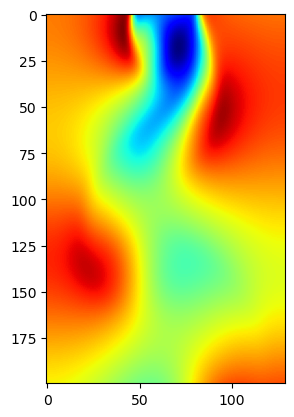

In [4]:
plt.figure()
plt.imshow(ux[0,:,:])
plt.show()

In [7]:
q.shape

(25800, 800)

In [10]:
from utils.decomposition import POD
pod = POD('float32')
q, q_mean, grid_shape = pod.prepare_data(ux,t_axis=0)
modes,lam,a,phi = pod.pod(q[:,:200],grid_shape,method='snapshot',restore_shape=True)

fr.utils.decomposition.snapshot_pod:144 [DEBUG] input as dtype float32.
fr.utils.decomposition.pod:57 [DEBUG] Reshpaing


In [11]:
modes.shape

(200, 129, 200)

In [12]:
grid_shape

[200, 129]

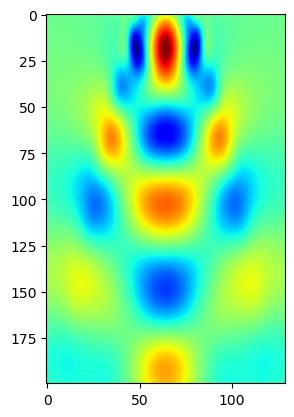

In [15]:
plt.figure()
plt.imshow(modes[:,:,2])

In [ ]:
mode1 = 

IndexError: Too many indices for array: 4 non-None/Ellipsis indices for dim 3.

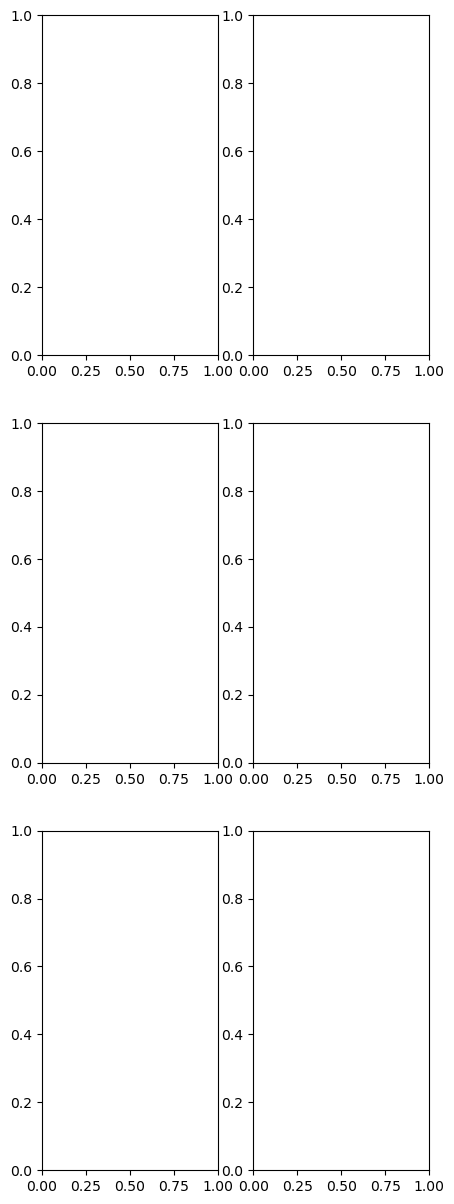

In [32]:
fig,axes = plt.subplots(3,2,figsize=(5,15))
for i in range(3):
    axes[i,0].imshow(modes[i,:,:,0])
    axes[i,1].imshow(modes[i,:,:,1])

In [2]:
import wandb
api = wandb.Api()
runs = api.runs("yaxinm/FlowReconstruction",filters={'config.snr':0})

# for run in runs:
#     run.config['snr'] = None
#     run.update()